# DiverseFlow and Particle Guidance Comparison

We consider the Probability Flow ODE admitted by the reverse SDE. Further, we utilize the analytical score function to define the flow.

We utilize parts of the [original codebase of Particle Guidance](https://github.com/gcorso/particle-guidance/blob/main/synthetic.ipynb) for this comparison.

## Definition of distribution and its score

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
N = 10 # number of modes in the radial Gaussian mixture
thetas = np.arange(N) * 2 * np.pi / N
cx = np.cos(thetas)
cy = np.sin(thetas)

In [ ]:
sigma2 = 0.005 # variance of each Gaussian mode

def sample():
    i = random.randint(0, N-1)
    s = np.random.multivariate_normal((cx[i], cy[i]), cov=[[sigma2, 0], [0, sigma2]])
    return s

In [4]:
samples = np.asarray([sample() for _ in range(10000)])

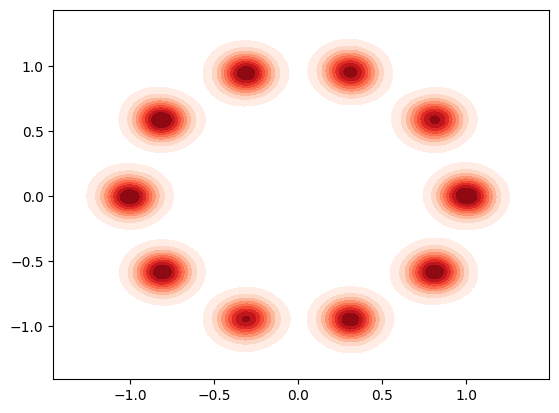

In [6]:
sns.kdeplot(x=samples[:, 0], y=samples[:, 1], cmap="Reds", fill=True, bw_adjust=.5)
plt.show()

In [ ]:
import torch

def gmm(centers, X, Y, var):
    ims = [
        np.exp(-((X - x) ** 2 + (Y - y) ** 2) / var) / np.sqrt(var) for x, y in centers
    ]
    return sum(ims)

# Score function of the Gaussian mixture, which acts as the flow model
def score(centers, X, Y, var):
    weights = np.asarray([np.exp(-((X - x) ** 2 + (Y - y) ** 2) / (2 * var)) for x, y in centers])
    weights = np.array(weights) / np.sum(weights, axis=0, keepdims=True)
    scores = np.asarray([[X - x, Y - y] for x, y in centers])
    return -np.sum(np.expand_dims(weights, axis=1) * scores, axis=0) / var


score([(x,y) for x,y in zip(cx,cy)], 0.1, 1, 0.1)

array([ 0.07365016, -0.60970014])

In [8]:
def figure_func(i, l_samples, save_name=None):
    samples = l_samples[i]
    tmp_sigma2 = sigma2 + (t_schedule[-1-i] if i<len(t_schedule) else 0)

    fig, ax = plt.subplots(1, figsize=(3, 3), dpi=150)
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)

    x, y = np.meshgrid(x, y)
    im = gmm(centers, x, y, tmp_sigma2)
    ax.imshow(im, vmin=0, cmap='Reds', extent=[-1.5, 1.5, 1.5, -1.5])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.scatter(samples[:, 0], samples[:,1], c="blue", marker='X', s=40, edgecolors="white", linewidths=0.5 )
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    if save_name is not None:
        plt.savefig(save_name)
    return fig

## Euclidean Kernel ParticleGuidance

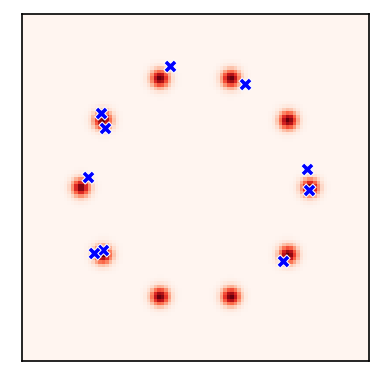

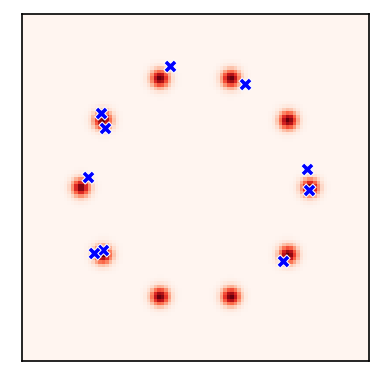

In [192]:
centers = np.asarray([(x,y) for x,y in zip(cx,cy)])

def particle_guidance(
    N,
    steps=1000,
    max_sigma2=1,
    min_sigma2=0.001,
    svgd_score_weight=1,
    svgd_repulsive_weight=1,
    noise_weight=1
):
    t_schedule = np.exp(np.linspace(np.log(min_sigma2), np.log(max_sigma2), steps))
    x = np.random.normal(0, np.sqrt(max_sigma2), (N, 2))
    list_samples = [x]
    
    svgd_score_weight = max(1, svgd_score_weight)
    
    for i in range(steps, 0, -1):
        var = t_schedule[i-1]
        d_sigma2 = t_schedule[i-1] - t_schedule[i-2] if i > 1 else t_schedule[i-1]
        score_x = score(centers, x[:, 0], x[:, 1], t_schedule[i-1] + sigma2).T
        
        if svgd_repulsive_weight > 0:
            diff = x[:, None] - x[None, :]
            d2_matrix = np.sum(diff*diff, axis=-1)
            h = np.sqrt(var)
            k = np.expand_dims(np.exp(-1 / h * d2_matrix), axis=-1)
            repulsive = np.sum(2 / h * diff * k, axis=1) / N

            
            score_diverse = svgd_score_weight * score_x + svgd_repulsive_weight * repulsive  
            
        else: # at W = 0 we do regular i.i.d. sampling
            score_diverse = score_x
            
        z = np.random.normal(0, 1, (N,2))  
        perturb_x = d_sigma2 * score_diverse + noise_weight * np.sqrt(d_sigma2) * z

        x = x + perturb_x
        list_samples.append(x)
    
    return list_samples, t_schedule


particle_list_samples, t_schedule = particle_guidance(N=10, steps=200, svgd_repulsive_weight=10, noise_weight=1)
figure_func(-1, particle_list_samples)

In [12]:
def count_different_centers(x, centers):
    d = x[:, None] - centers[None, :]
    distances = np.sum(d * d, axis=-1)
    minimum = np.argmin(distances, axis=1)
    sums = np.zeros(len(centers))
    np.add.at(sums, minimum, 1)
    return np.sum(sums>0)
    
count_different_centers(particle_list_samples[-1], np.asarray(centers))

8

In [238]:
def count_different_centers_wrap(method_fn, num_trials, **kwargs):
    vals = []
    for i in range(num_trials):
        x = method_fn(N=10, **kwargs)[0][-1]
        v = count_different_centers(x, centers)
        vals.append(v)
    print(vals)
    return sum(vals) / num_trials

count_different_centers_wrap(method_fn=particle_guidance, num_trials=100, steps=200, svgd_repulsive_weight=10, noise_weight=1)

[7, 7, 8, 8, 8, 7, 7, 8, 7, 7, 6, 8, 8, 8, 8, 6, 6, 7, 7, 8, 8, 7, 6, 7, 7, 6, 5, 9, 8, 7, 7, 7, 8, 7, 8, 8, 7, 7, 9, 6, 8, 8, 9, 8, 7, 6, 7, 8, 9, 8, 8, 9, 8, 6, 8, 7, 7, 8, 7, 8, 6, 7, 9, 8, 7, 8, 7, 7, 8, 5, 9, 9, 8, 8, 8, 9, 8, 8, 6, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 9, 7, 7, 6, 5, 7, 7, 8, 8, 7]


7.39

In [205]:
possible_svgd_repulsive_weights = np.array([0, *np.exp(np.linspace(np.log(1), np.log(100), 10))])
possible_noise_weights = np.exp(np.linspace(np.log(0.01), np.log(1), 5))
possible_svgd_repulsive_weights, possible_noise_weights

(array([  0.        ,   1.        ,   1.66810054,   2.7825594 ,
          4.64158883,   7.74263683,  12.91549665,  21.5443469 ,
         35.93813664,  59.94842503, 100.        ]),
 array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]))

In [206]:
import tqdm 

values = [[0 for j in range(len(possible_noise_weights))] for i in range(len(possible_svgd_repulsive_weights))]

for i in tqdm.tqdm(range(len(possible_svgd_repulsive_weights))):
    for j in range(len(possible_noise_weights)):
        values[i][j] = count_different_centers_wrap(
            method_fn=particle_guidance,
            num_trials=100,
            noise_weight=possible_noise_weights[j],
            svgd_repulsive_weight=possible_svgd_repulsive_weights[i],
            steps=200,
        )


  0%|          | 0/11 [00:00<?, ?it/s]

[7, 7, 7, 7, 9, 8, 6, 6, 8, 6, 7, 6, 6, 7, 6, 8, 7, 7, 6, 6, 8, 5, 7, 6, 8, 6, 6, 7, 5, 8, 6, 7, 6, 7, 6, 4, 5, 8, 5, 5, 6, 6, 7, 8, 7, 7, 6, 6, 7, 6, 8, 6, 6, 7, 8, 7, 8, 7, 4, 5, 6, 5, 5, 5, 7, 7, 8, 7, 8, 5, 6, 6, 7, 7, 5, 8, 8, 7, 5, 7, 6, 6, 8, 8, 7, 7, 5, 7, 8, 6, 9, 7, 6, 6, 9, 6, 7, 7, 7, 6]
[8, 6, 6, 8, 7, 7, 7, 7, 6, 6, 7, 6, 7, 7, 6, 5, 7, 5, 6, 8, 5, 4, 5, 7, 7, 6, 7, 7, 5, 8, 7, 8, 6, 8, 7, 6, 7, 7, 8, 7, 6, 7, 7, 9, 8, 6, 7, 6, 7, 6, 5, 6, 9, 6, 5, 9, 5, 4, 6, 4, 5, 7, 6, 7, 6, 7, 8, 6, 7, 7, 7, 6, 7, 7, 8, 6, 5, 6, 8, 7, 5, 5, 6, 7, 7, 8, 5, 7, 7, 5, 7, 6, 5, 6, 7, 8, 7, 5, 7, 6]
[7, 7, 8, 6, 7, 5, 8, 8, 7, 8, 4, 6, 7, 5, 6, 6, 6, 8, 5, 6, 7, 7, 5, 7, 6, 7, 5, 7, 6, 6, 7, 6, 8, 8, 8, 7, 5, 5, 7, 7, 7, 7, 5, 6, 6, 7, 7, 8, 6, 7, 6, 6, 6, 5, 7, 7, 8, 6, 6, 8, 7, 8, 6, 8, 5, 7, 6, 6, 6, 5, 7, 6, 6, 7, 8, 8, 5, 6, 6, 5, 5, 7, 7, 4, 5, 6, 7, 5, 6, 6, 5, 8, 7, 6, 8, 6, 6, 6, 6, 4]
[7, 5, 7, 7, 6, 7, 7, 7, 6, 4, 7, 5, 7, 8, 5, 7, 7, 5, 5, 8, 7, 6, 8, 7, 7, 7, 7, 7, 7, 6, 7, 7, 

  9%|▉         | 1/11 [00:10<01:44, 10.45s/it]

[7, 6, 6, 8, 7, 8, 7, 5, 6, 7, 6, 6, 6, 7, 7, 6, 7, 8, 6, 8, 6, 7, 6, 7, 7, 9, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 9, 8, 6, 5, 6, 7, 8, 6, 8, 6, 7, 7, 7, 8, 6, 6, 5, 7, 7, 5, 6, 7, 5, 5, 7, 6, 5, 7, 7, 7, 7, 5, 8, 7, 5, 5, 6, 6, 8, 6, 7, 7, 7, 8, 6, 7, 7, 7, 6, 6, 6, 7, 7, 7, 6, 8, 6, 5, 6, 5, 7, 8, 6, 5]
[7, 7, 7, 9, 7, 7, 8, 8, 7, 7, 7, 8, 6, 7, 6, 6, 6, 6, 8, 5, 7, 8, 7, 7, 7, 8, 7, 8, 9, 6, 6, 6, 5, 7, 8, 7, 9, 8, 7, 8, 9, 6, 8, 7, 8, 7, 8, 9, 8, 8, 7, 5, 8, 7, 5, 8, 8, 7, 6, 7, 6, 7, 4, 6, 6, 7, 8, 8, 8, 7, 8, 8, 7, 8, 8, 7, 8, 8, 8, 6, 7, 6, 7, 7, 9, 8, 8, 8, 6, 6, 8, 8, 6, 8, 5, 7, 7, 6, 6, 8]
[7, 7, 7, 7, 8, 7, 6, 7, 8, 7, 8, 8, 6, 8, 7, 8, 7, 9, 6, 7, 7, 9, 7, 8, 6, 9, 7, 7, 6, 6, 9, 7, 6, 6, 7, 8, 6, 8, 8, 6, 6, 7, 9, 6, 8, 7, 7, 8, 8, 7, 6, 7, 8, 7, 7, 7, 9, 7, 8, 6, 5, 6, 6, 6, 8, 7, 7, 7, 7, 8, 7, 10, 8, 8, 7, 7, 6, 7, 7, 8, 7, 6, 7, 7, 7, 8, 6, 5, 8, 7, 8, 6, 8, 7, 8, 6, 7, 7, 8, 6]
[5, 7, 7, 6, 7, 8, 9, 7, 8, 6, 8, 7, 7, 7, 7, 8, 7, 9, 7, 5, 8, 9, 6, 8, 8, 7, 8, 7, 7, 6, 8, 7,

 18%|█▊        | 2/11 [00:23<01:48, 12.10s/it]

[5, 7, 6, 8, 5, 8, 7, 7, 5, 6, 8, 7, 7, 6, 7, 6, 6, 8, 8, 7, 7, 4, 7, 5, 6, 5, 9, 8, 7, 8, 7, 6, 5, 5, 6, 6, 8, 7, 6, 5, 7, 5, 7, 8, 7, 5, 9, 6, 8, 7, 8, 8, 7, 7, 7, 7, 6, 8, 6, 6, 8, 6, 7, 6, 7, 7, 8, 8, 6, 7, 6, 8, 6, 7, 7, 7, 5, 5, 7, 6, 6, 7, 6, 6, 6, 6, 5, 6, 6, 5, 8, 7, 8, 7, 6, 6, 9, 6, 7, 6]
[9, 7, 7, 9, 8, 8, 7, 7, 9, 8, 8, 8, 8, 9, 6, 8, 8, 6, 9, 7, 6, 7, 8, 8, 8, 7, 7, 6, 8, 7, 6, 9, 6, 7, 7, 7, 6, 8, 7, 8, 8, 8, 7, 8, 7, 7, 8, 8, 7, 8, 8, 9, 8, 7, 7, 8, 7, 7, 7, 6, 7, 8, 9, 7, 7, 8, 8, 8, 7, 7, 8, 7, 8, 9, 8, 7, 7, 9, 5, 8, 7, 7, 7, 7, 8, 8, 7, 6, 8, 7, 6, 8, 8, 8, 6, 7, 7, 8, 8, 7]
[9, 6, 8, 8, 7, 7, 7, 8, 8, 8, 7, 7, 5, 7, 7, 7, 7, 6, 9, 8, 7, 8, 8, 5, 7, 8, 6, 9, 8, 8, 8, 8, 8, 9, 7, 7, 8, 6, 6, 7, 8, 8, 9, 7, 7, 8, 9, 7, 8, 7, 8, 8, 8, 7, 9, 8, 7, 7, 8, 7, 8, 6, 6, 10, 6, 7, 9, 7, 6, 7, 10, 8, 8, 7, 8, 9, 7, 6, 7, 8, 7, 7, 8, 7, 8, 9, 8, 7, 9, 7, 7, 7, 8, 8, 6, 6, 8, 7, 7, 9]
[7, 8, 7, 8, 7, 7, 7, 8, 6, 5, 7, 9, 6, 7, 8, 9, 6, 6, 7, 8, 8, 7, 7, 8, 8, 7, 7, 7, 8, 7, 7, 8

 27%|██▋       | 3/11 [00:37<01:42, 12.76s/it]

[5, 7, 6, 5, 7, 7, 6, 6, 7, 4, 7, 6, 8, 8, 6, 8, 7, 8, 7, 6, 8, 8, 7, 6, 6, 7, 9, 7, 8, 6, 6, 7, 7, 7, 6, 8, 7, 7, 7, 7, 7, 6, 6, 9, 7, 9, 6, 8, 8, 6, 4, 8, 5, 7, 6, 8, 8, 7, 9, 6, 8, 6, 6, 6, 7, 5, 7, 7, 6, 6, 8, 5, 6, 7, 7, 8, 5, 5, 7, 7, 5, 5, 7, 6, 7, 6, 8, 6, 8, 6, 7, 7, 6, 6, 6, 7, 5, 7, 7, 8]
[7, 7, 7, 8, 9, 8, 7, 7, 6, 7, 9, 8, 7, 8, 7, 7, 8, 8, 8, 7, 7, 7, 7, 8, 7, 8, 9, 9, 8, 8, 8, 9, 8, 7, 7, 9, 8, 8, 7, 8, 7, 8, 7, 8, 8, 8, 8, 9, 7, 8, 7, 7, 7, 6, 7, 8, 8, 8, 9, 7, 8, 7, 8, 7, 8, 9, 9, 8, 8, 8, 7, 8, 7, 7, 7, 8, 7, 7, 9, 6, 9, 8, 7, 7, 8, 8, 9, 8, 8, 6, 8, 9, 8, 8, 8, 8, 9, 7, 8, 8]
[8, 8, 7, 9, 8, 8, 7, 7, 8, 7, 7, 8, 7, 7, 7, 8, 8, 8, 7, 10, 8, 9, 6, 8, 8, 7, 8, 9, 7, 8, 8, 8, 9, 7, 7, 7, 8, 7, 8, 8, 8, 8, 9, 8, 7, 8, 8, 9, 7, 8, 7, 8, 7, 8, 9, 7, 8, 8, 7, 9, 8, 9, 8, 8, 8, 7, 8, 9, 9, 8, 8, 8, 8, 8, 6, 7, 9, 9, 7, 7, 6, 9, 8, 9, 6, 9, 7, 6, 9, 9, 8, 7, 7, 9, 8, 8, 8, 7, 8, 6]
[9, 7, 8, 8, 8, 8, 6, 6, 8, 7, 9, 9, 7, 7, 7, 9, 7, 7, 8, 9, 8, 8, 6, 7, 9, 7, 8, 8, 8, 7, 8, 8,

 36%|███▋      | 4/11 [00:50<01:30, 12.98s/it]

[9, 7, 8, 9, 6, 7, 6, 7, 5, 5, 7, 5, 7, 7, 7, 5, 6, 7, 7, 8, 7, 7, 6, 7, 7, 6, 6, 8, 6, 6, 9, 7, 6, 7, 8, 6, 7, 6, 8, 7, 7, 6, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 6, 8, 7, 7, 5, 6, 7, 7, 7, 6, 7, 8, 8, 7, 8, 9, 6, 6, 8, 6, 5, 7, 8, 7, 5, 7, 6, 7, 7, 7, 5, 8, 7, 6, 7, 6, 6, 7, 7, 6, 5, 7, 8, 8, 8, 7, 7, 8]
[8, 8, 8, 8, 9, 10, 9, 10, 8, 9, 9, 8, 8, 9, 6, 8, 7, 8, 9, 9, 7, 8, 8, 8, 9, 9, 8, 8, 7, 9, 9, 9, 10, 8, 8, 7, 8, 8, 8, 9, 8, 7, 7, 9, 9, 8, 9, 8, 8, 9, 9, 9, 7, 9, 9, 9, 7, 7, 8, 9, 10, 8, 8, 8, 6, 8, 7, 9, 9, 8, 7, 8, 9, 9, 9, 8, 7, 8, 9, 9, 8, 8, 9, 7, 8, 8, 8, 7, 9, 10, 8, 9, 7, 7, 8, 8, 9, 9, 8, 9]
[9, 8, 8, 9, 9, 9, 8, 7, 9, 9, 8, 7, 7, 8, 8, 8, 10, 7, 9, 9, 8, 7, 7, 8, 8, 8, 10, 9, 9, 9, 8, 9, 9, 8, 8, 9, 8, 8, 8, 7, 8, 7, 9, 7, 8, 9, 9, 9, 7, 7, 8, 9, 8, 8, 8, 8, 9, 8, 7, 9, 9, 8, 8, 9, 8, 8, 9, 8, 8, 8, 7, 7, 9, 8, 8, 9, 9, 8, 8, 8, 7, 8, 9, 7, 10, 7, 8, 9, 8, 8, 9, 8, 9, 8, 7, 7, 9, 8, 8, 7]
[8, 7, 9, 6, 7, 8, 9, 8, 8, 10, 7, 8, 8, 8, 9, 9, 8, 8, 9, 9, 8, 8, 8, 9, 9, 9, 8, 7, 9, 

 45%|████▌     | 5/11 [01:03<01:17, 12.99s/it]

[7, 8, 7, 8, 8, 8, 9, 8, 8, 6, 7, 7, 8, 8, 7, 5, 6, 7, 7, 7, 6, 5, 7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 8, 7, 7, 7, 8, 7, 7, 8, 7, 6, 9, 7, 9, 8, 8, 7, 5, 7, 7, 7, 6, 6, 6, 8, 7, 7, 7, 7, 7, 8, 7, 6, 5, 8, 7, 6, 8, 6, 6, 8, 8, 7, 7, 8, 6, 7, 6, 6, 6, 7, 7, 7, 7, 8, 6, 7, 5, 7, 6, 6, 6, 5, 7, 7, 6, 7, 9]
[9, 8, 7, 10, 8, 9, 8, 9, 8, 9, 8, 8, 8, 9, 8, 8, 8, 9, 8, 7, 7, 8, 9, 9, 8, 8, 9, 9, 9, 9, 10, 9, 8, 9, 9, 9, 6, 9, 9, 9, 7, 9, 9, 8, 9, 9, 7, 8, 9, 9, 9, 9, 8, 8, 7, 8, 8, 9, 9, 9, 9, 8, 8, 9, 9, 10, 9, 9, 8, 8, 8, 8, 9, 8, 10, 10, 9, 8, 9, 9, 9, 8, 8, 7, 9, 9, 9, 8, 10, 8, 8, 6, 9, 8, 9, 9, 8, 9, 7, 9]
[9, 8, 9, 10, 9, 7, 8, 8, 9, 8, 9, 8, 8, 9, 9, 8, 8, 8, 9, 10, 10, 9, 9, 9, 8, 8, 8, 7, 9, 9, 8, 7, 7, 8, 9, 9, 8, 8, 8, 10, 9, 9, 8, 9, 8, 8, 8, 8, 7, 7, 10, 8, 8, 8, 9, 8, 8, 8, 8, 8, 9, 9, 9, 7, 7, 8, 9, 10, 9, 10, 9, 9, 9, 8, 10, 9, 8, 8, 8, 9, 9, 9, 8, 10, 8, 9, 9, 8, 7, 7, 8, 7, 9, 9, 7, 9, 9, 8, 9, 9]
[9, 8, 9, 9, 8, 9, 7, 9, 9, 8, 9, 9, 9, 10, 8, 9, 8, 8, 8, 9, 8, 7, 8, 8, 8, 8, 8,

 55%|█████▍    | 6/11 [01:16<01:04, 12.94s/it]

[7, 8, 6, 6, 7, 5, 9, 8, 6, 9, 7, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 7, 8, 6, 6, 7, 8, 7, 7, 8, 8, 7, 7, 8, 8, 7, 7, 7, 8, 7, 7, 8, 9, 7, 7, 8, 8, 7, 7, 8, 8, 7, 8, 7, 7, 7, 7, 7, 8, 8, 7, 7, 6, 7, 7, 8, 7, 8, 7, 7, 7, 7, 8, 7, 7, 6, 6, 7, 5, 5, 8, 7, 6, 7, 7, 7, 8, 8, 7, 6, 6, 7, 8, 7, 8, 7, 9, 7, 8, 6]
[8, 8, 9, 9, 8, 9, 10, 10, 10, 10, 8, 9, 10, 9, 10, 10, 9, 8, 8, 10, 9, 8, 9, 8, 9, 9, 8, 9, 9, 9, 8, 9, 8, 7, 8, 8, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 9, 10, 8, 7, 9, 9, 8, 8, 9, 10, 9, 9, 9, 10, 9, 8, 9, 9, 7, 8, 8, 7, 8, 8, 9, 9, 8, 10, 8, 8, 8, 9, 9, 8, 8, 10, 9, 8, 7, 9, 9, 8, 9, 9, 10, 9, 7, 8, 8]
[8, 9, 8, 9, 9, 8, 8, 8, 9, 9, 8, 9, 8, 8, 7, 9, 9, 10, 9, 9, 8, 9, 8, 9, 8, 9, 8, 9, 9, 8, 8, 8, 9, 8, 8, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 10, 9, 8, 8, 10, 8, 10, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 9, 9, 8, 9, 9, 9, 9, 9, 10, 9, 8, 8, 8, 9, 9, 8, 8, 7, 9, 9, 9, 8, 9, 9, 9]
[8, 8, 8, 8, 9, 8, 9, 8, 8, 9, 10, 7, 9, 9, 8, 9, 9, 10, 9, 9, 9, 9, 7, 9, 9, 

 64%|██████▎   | 7/11 [01:29<00:51, 12.98s/it]

[9, 8, 8, 7, 8, 8, 8, 9, 7, 7, 8, 6, 7, 8, 7, 8, 6, 7, 8, 8, 8, 7, 7, 8, 7, 7, 9, 7, 7, 8, 8, 7, 7, 8, 8, 8, 6, 9, 8, 9, 7, 7, 8, 8, 8, 7, 8, 9, 7, 8, 8, 9, 9, 7, 6, 6, 6, 6, 9, 7, 8, 7, 9, 9, 8, 8, 8, 6, 8, 9, 7, 9, 8, 9, 7, 7, 8, 7, 7, 8, 8, 9, 7, 7, 8, 7, 7, 7, 9, 8, 6, 7, 9, 8, 8, 8, 6, 6, 9, 7]
[8, 9, 9, 9, 10, 9, 10, 10, 8, 7, 9, 9, 9, 10, 8, 8, 9, 8, 9, 7, 9, 7, 8, 9, 7, 8, 8, 9, 9, 9, 9, 8, 10, 9, 9, 8, 8, 8, 8, 8, 10, 9, 9, 8, 9, 10, 8, 9, 8, 9, 9, 9, 10, 8, 9, 8, 9, 9, 9, 7, 7, 9, 10, 8, 8, 8, 8, 9, 8, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 10, 9, 9, 10, 10, 8, 9, 8, 8, 9, 8, 10, 8, 9, 9, 9, 7, 9, 9, 10, 9]
[7, 8, 9, 9, 9, 8, 8, 8, 9, 9, 8, 9, 8, 8, 9, 9, 8, 9, 9, 10, 8, 7, 9, 9, 9, 10, 7, 8, 9, 10, 8, 10, 9, 10, 7, 9, 8, 8, 9, 8, 10, 8, 9, 9, 9, 8, 8, 9, 8, 8, 8, 10, 8, 9, 10, 9, 9, 8, 9, 8, 8, 10, 9, 9, 10, 9, 8, 8, 8, 8, 9, 9, 9, 9, 7, 8, 8, 8, 9, 9, 9, 9, 9, 8, 9, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 9, 8, 8, 9]
[8, 8, 8, 9, 8, 8, 10, 8, 9, 9, 8, 8, 9, 9, 10, 9, 10, 10, 9, 9, 7, 8, 10

 73%|███████▎  | 8/11 [01:42<00:39, 13.04s/it]

[7, 7, 9, 8, 7, 7, 9, 7, 9, 9, 7, 9, 9, 8, 7, 8, 9, 8, 8, 6, 8, 8, 9, 7, 8, 8, 8, 7, 8, 7, 9, 8, 9, 9, 8, 8, 7, 7, 7, 8, 9, 8, 7, 9, 9, 8, 7, 8, 8, 8, 8, 7, 7, 9, 8, 9, 8, 7, 8, 8, 8, 7, 7, 9, 7, 8, 8, 9, 8, 8, 9, 7, 7, 8, 9, 7, 10, 8, 9, 7, 8, 7, 8, 7, 7, 9, 6, 7, 8, 8, 8, 6, 8, 8, 8, 9, 8, 7, 9, 7]
[9, 8, 9, 9, 10, 8, 8, 9, 10, 8, 9, 9, 9, 9, 10, 7, 8, 9, 8, 8, 8, 10, 9, 10, 9, 9, 8, 9, 8, 8, 10, 9, 7, 8, 9, 10, 9, 8, 9, 9, 9, 7, 8, 9, 9, 9, 9, 9, 8, 9, 8, 8, 9, 10, 8, 8, 8, 8, 10, 9, 9, 8, 9, 9, 10, 9, 9, 9, 8, 9, 8, 9, 10, 8, 8, 10, 8, 8, 8, 8, 9, 9, 9, 8, 9, 8, 8, 9, 10, 9, 9, 8, 8, 8, 8, 8, 10, 8, 9, 8]
[9, 8, 9, 8, 8, 9, 8, 8, 9, 9, 9, 9, 10, 7, 9, 9, 8, 8, 8, 8, 8, 10, 8, 8, 9, 9, 8, 9, 8, 9, 9, 9, 10, 8, 9, 9, 9, 10, 8, 9, 8, 9, 9, 8, 8, 8, 9, 8, 8, 8, 8, 8, 9, 9, 8, 8, 10, 8, 8, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 8, 8, 9, 9, 10, 9, 8, 9, 9, 9, 10, 9, 10, 8, 9, 9, 9, 8, 10, 10, 8, 10, 9, 8, 9, 8, 9]
[9, 9, 10, 10, 9, 9, 9, 10, 9, 9, 9, 8, 10, 10, 7, 9, 9, 8, 9, 8, 8, 9,

 82%|████████▏ | 9/11 [01:55<00:26, 13.04s/it]

[9, 9, 8, 8, 9, 9, 8, 8, 9, 9, 8, 8, 8, 8, 9, 7, 9, 7, 8, 7, 8, 9, 9, 9, 8, 9, 8, 9, 8, 8, 8, 10, 8, 7, 8, 10, 9, 8, 8, 7, 9, 8, 8, 9, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 9, 7, 9, 9, 7, 8, 9, 8, 9, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 6, 8, 6, 8, 7, 7, 8, 8, 7, 10, 8, 8, 8, 9, 8, 9, 8, 7, 8, 9, 9, 8, 9, 8]
[10, 9, 9, 9, 8, 10, 8, 8, 8, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 10, 10, 8, 8, 9, 9, 8, 8, 10, 9, 8, 8, 9, 8, 10, 8, 8, 9, 10, 9, 9, 8, 10, 8, 8, 8, 9, 8, 7, 10, 8, 8, 10, 9, 9, 9, 10, 10, 10, 8, 9, 8, 9, 9, 9, 10, 8, 9, 8, 9, 10, 10, 10, 8, 7, 9, 9, 9, 10, 8, 9, 8, 10, 9, 9, 9, 9, 10, 9, 9, 9, 8, 9, 8, 8, 9, 8, 8]
[9, 9, 8, 9, 10, 8, 9, 8, 9, 9, 9, 8, 9, 8, 8, 8, 10, 10, 8, 9, 9, 9, 8, 9, 7, 8, 9, 8, 9, 8, 7, 9, 9, 9, 9, 9, 9, 9, 8, 10, 9, 8, 9, 9, 8, 9, 8, 9, 8, 10, 10, 9, 9, 9, 8, 8, 9, 10, 9, 8, 8, 8, 9, 9, 8, 10, 8, 9, 9, 10, 8, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 8, 9, 7, 8, 9, 8, 9, 9, 10, 9]
[10, 9, 10, 9, 9, 9, 10, 8, 8, 9, 10, 9, 9, 9, 9, 8, 9, 8, 8, 9,

 91%|█████████ | 10/11 [02:08<00:12, 12.99s/it]

[8, 9, 8, 8, 7, 8, 8, 9, 9, 8, 9, 9, 8, 9, 9, 9, 8, 9, 8, 8, 9, 9, 8, 10, 9, 8, 9, 7, 8, 8, 8, 8, 10, 8, 8, 9, 7, 9, 7, 8, 8, 8, 9, 9, 7, 7, 8, 7, 8, 7, 7, 8, 8, 9, 9, 7, 9, 7, 8, 8, 9, 8, 9, 9, 8, 8, 7, 9, 8, 8, 8, 10, 8, 10, 8, 8, 8, 9, 9, 8, 8, 8, 8, 10, 8, 9, 8, 8, 9, 9, 9, 8, 8, 7, 9, 8, 8, 10, 9, 8]
[9, 8, 9, 10, 8, 8, 10, 8, 10, 9, 8, 8, 8, 7, 9, 9, 10, 10, 8, 9, 9, 8, 9, 9, 9, 10, 8, 9, 9, 9, 9, 8, 8, 9, 9, 9, 8, 8, 7, 8, 7, 8, 9, 9, 8, 9, 10, 9, 10, 8, 7, 9, 10, 9, 9, 8, 8, 9, 9, 7, 9, 10, 8, 8, 9, 9, 8, 8, 9, 8, 9, 9, 8, 7, 9, 9, 9, 8, 10, 9, 8, 8, 8, 7, 10, 9, 10, 9, 8, 9, 8, 9, 7, 9, 8, 9, 9, 8, 9, 8]
[9, 8, 8, 8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 9, 8, 9, 8, 10, 9, 8, 8, 9, 9, 9, 10, 8, 8, 9, 9, 9, 9, 7, 9, 9, 9, 7, 8, 8, 9, 9, 10, 9, 8, 9, 8, 8, 10, 8, 9, 10, 8, 9, 10, 8, 8, 8, 9, 10, 7, 8, 9, 8, 10, 9, 10, 8, 10, 10, 9, 8, 8, 8, 8, 9, 10, 9, 8, 10, 10, 8, 8, 9, 10, 9, 9, 10, 8, 9, 10, 10, 8, 9, 9, 9, 8, 8, 8, 9, 9]
[8, 8, 8, 9, 8, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 8, 7, 8, 9, 8

100%|██████████| 11/11 [02:21<00:00, 12.88s/it]

[8, 9, 8, 8, 9, 8, 7, 8, 8, 8, 8, 9, 9, 9, 8, 9, 8, 9, 8, 9, 9, 9, 8, 9, 9, 7, 9, 9, 8, 9, 8, 8, 8, 7, 9, 9, 8, 7, 9, 8, 9, 7, 8, 9, 8, 8, 7, 9, 9, 8, 9, 9, 9, 8, 8, 8, 8, 9, 8, 8, 8, 7, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 7, 9, 10, 8, 9, 7, 9, 10, 7, 8, 10, 8, 8, 8, 8, 9, 10, 9, 8, 8, 9, 7, 8, 8, 8, 9, 10, 8]


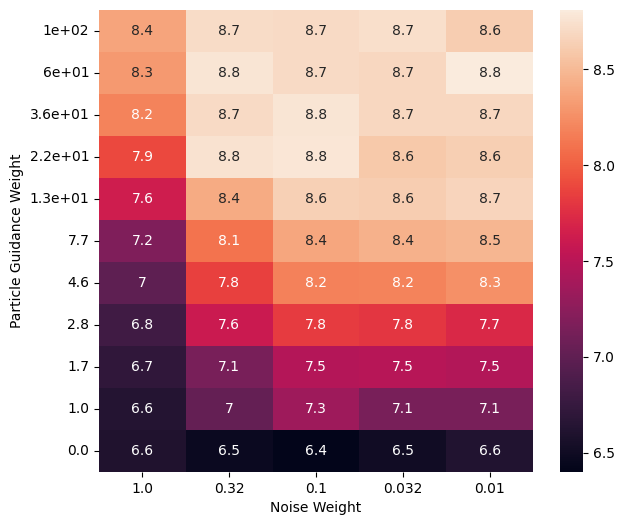

In [207]:
values_reversed = list(reversed([list(reversed(v)) for v in values]))
val_arr = np.array(values_reversed)

plt.figure()
ax = sns.heatmap(val_arr, annot=True,)
ax.set_xticks(0.5 + np.arange(len(possible_noise_weights)), labels = [f'{s:.02}' for s in list(reversed(possible_noise_weights))], rotation=00)
ax.set_yticks(0.5 + np.arange(len(possible_svgd_repulsive_weights)), labels=[f'{s:.02}' for s in list(reversed(possible_svgd_repulsive_weights))], rotation=0)
plt.xlabel("Noise Weight")
plt.ylabel("Particle Guidance Weight")
plt.show()

In [256]:
np.save("pg_vals.npy", val_arr)

## Euclidean Kernel DiverseFlow

We now use an identical kernel with DiverseFlow instead.

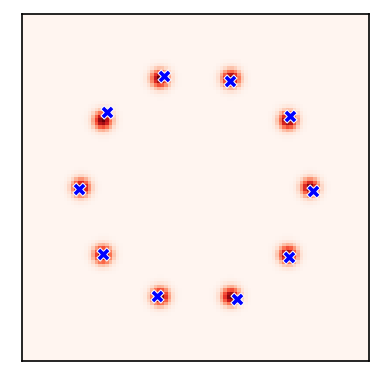

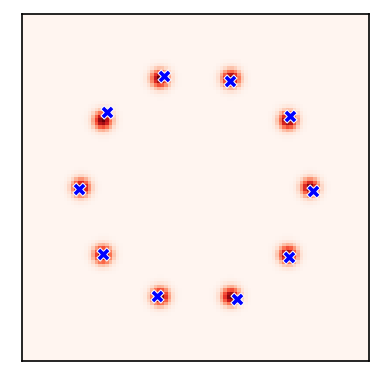

In [ ]:
def dpp(x, var):
    x = torch.from_numpy(x).requires_grad_(True)
    
    diff = x[:, None] - x[None, :]
    d2_matrix = torch.sum(diff*diff, axis=-1)
    h = np.sqrt(var)
    L = torch.exp(-1 / h * d2_matrix)
    
    # negative log-likelihood of DPP = -log(det(L)/det(L+I))
    I = torch.eye(L.shape[0])
    loss = -(torch.logdet(L) - torch.logdet(L + I))
    grad = torch.autograd.grad(loss, x)[0].numpy().reshape(x.shape[0], -1)
    
    # get the unit diversity direction
    grad_norm = np.linalg.norm(grad, axis=1)
    grad_norm = np.where(grad_norm > 0, grad_norm, 1)
    grad = (grad / grad_norm[:, None]).reshape(x.shape)
    
    return -grad
    

def diverseflow(
    N,
    steps=1000,
    max_sigma2=1,
    min_sigma2=0.001,
    W=1,
    noise_weight=1,
    alpha=0.5
):
    t_schedule = np.exp(np.linspace(np.log(min_sigma2), np.log(max_sigma2), steps))
    x = np.random.normal(0, np.sqrt(max_sigma2), (N, 2))
    list_samples = [x]
    
    for i in range(steps, 0, -1):
        var = t_schedule[i-1]
        d_sigma2 = t_schedule[i-1] - t_schedule[i-2] if i > 1 else t_schedule[i-1]
        score_x = score(centers, x[:, 0], x[:, 1], t_schedule[i-1] + sigma2).T
        
        repulsive_weight = W * alpha
        score_weight = max(1, W * (1 - alpha))
        
        repulsive = dpp(x, var)
        score_diverse = score_weight * score_x + repulsive_weight * repulsive

        z = np.random.normal(0, 1, (N,2))
        perturb_x = d_sigma2 * score_diverse + noise_weight * np.sqrt(d_sigma2) * z

        x = x + perturb_x
        list_samples.append(x)
    
    return list_samples, t_schedule

DF_WEIGHT = 10
df_list_samples, t_schedule = diverseflow(N=10, steps=200, W=DF_WEIGHT, noise_weight=1)
figure_func(-1, df_list_samples)

In [209]:
possible_W =  np.array([0, *np.exp(np.linspace(np.log(1), np.log(100), 10))])
possible_noise_weights = np.exp(np.linspace(np.log(0.01), np.log(1), 5))
possible_W, possible_noise_weights

(array([  0.        ,   1.        ,   1.66810054,   2.7825594 ,
          4.64158883,   7.74263683,  12.91549665,  21.5443469 ,
         35.93813664,  59.94842503, 100.        ]),
 array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]))

In [247]:
import tqdm 

values_df = [[0 for j in range(len(possible_noise_weights))] for i in range(len(possible_W))]

for i in tqdm.tqdm(range(len(possible_W))):
    for j in range(len(possible_noise_weights)):
        values_df[i][j] = count_different_centers_wrap(
            method_fn=diverseflow,
            num_trials=100,
            noise_weight=possible_noise_weights[j],
            W=possible_svgd_repulsive_weights[i],
            steps=200,
        )


  0%|          | 0/11 [00:00<?, ?it/s]

[6, 6, 6, 6, 7, 7, 7, 8, 6, 6, 6, 8, 7, 6, 7, 8, 9, 7, 6, 6, 6, 6, 5, 7, 8, 7, 8, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 6, 6, 7, 6, 8, 6, 7, 5, 5, 9, 7, 7, 6, 8, 6, 8, 7, 6, 6, 7, 5, 5, 7, 6, 6, 8, 7, 6, 6, 7, 5, 7, 6, 6, 7, 5, 7, 7, 6, 7, 9, 7, 6, 3, 5, 7, 8, 6, 7, 6, 6, 4, 6, 6, 6, 6, 8, 6, 6, 5, 6]
[4, 4, 8, 7, 5, 8, 7, 7, 6, 7, 6, 8, 9, 6, 7, 7, 6, 7, 5, 7, 5, 7, 7, 8, 6, 7, 6, 7, 6, 6, 5, 6, 5, 5, 7, 6, 7, 7, 7, 4, 7, 7, 6, 6, 6, 7, 7, 7, 7, 8, 5, 7, 6, 6, 8, 7, 6, 7, 6, 7, 5, 8, 5, 6, 8, 7, 8, 6, 6, 5, 7, 6, 7, 7, 5, 6, 5, 5, 7, 7, 5, 7, 5, 7, 5, 5, 6, 8, 8, 7, 6, 9, 5, 6, 7, 8, 5, 8, 8, 8]
[4, 7, 6, 6, 6, 8, 8, 6, 6, 7, 6, 6, 8, 7, 7, 7, 7, 7, 8, 6, 8, 5, 6, 7, 6, 5, 8, 6, 8, 7, 7, 7, 7, 5, 8, 7, 7, 7, 7, 6, 5, 8, 7, 7, 6, 8, 9, 6, 6, 6, 7, 7, 7, 7, 6, 7, 8, 7, 7, 7, 8, 6, 7, 6, 7, 5, 8, 5, 5, 6, 6, 7, 8, 6, 5, 6, 7, 6, 7, 7, 6, 7, 8, 6, 7, 6, 5, 5, 7, 5, 6, 6, 6, 6, 7, 6, 5, 8, 6, 6]
[5, 6, 7, 7, 8, 7, 6, 8, 6, 7, 8, 6, 6, 7, 7, 5, 6, 5, 6, 5, 6, 8, 6, 6, 7, 6, 5, 8, 6, 7, 8, 5, 

  9%|▉         | 1/11 [00:10<01:46, 10.67s/it]

[9, 7, 6, 7, 6, 7, 8, 7, 5, 6, 8, 6, 7, 7, 8, 7, 6, 7, 7, 4, 6, 6, 6, 8, 7, 8, 6, 6, 8, 6, 5, 7, 6, 6, 6, 7, 6, 7, 7, 7, 6, 5, 7, 8, 6, 8, 7, 5, 5, 6, 7, 8, 3, 6, 8, 6, 6, 8, 7, 5, 7, 6, 8, 7, 8, 6, 6, 8, 7, 6, 8, 6, 8, 6, 7, 8, 6, 6, 7, 8, 7, 7, 6, 7, 7, 7, 7, 8, 8, 7, 7, 7, 6, 6, 8, 5, 7, 8, 6, 6]
[7, 8, 8, 8, 9, 7, 8, 7, 7, 9, 9, 6, 8, 9, 9, 7, 8, 7, 9, 8, 8, 8, 8, 9, 8, 8, 9, 7, 9, 8, 9, 8, 9, 7, 8, 9, 9, 8, 7, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 8, 9, 8, 8, 9, 7, 8, 9, 10, 8, 8, 8, 8, 8, 9, 8, 8, 8, 7, 8, 7, 8, 6, 7, 7, 8, 9, 10, 6, 9, 8, 8, 9, 8, 7, 9, 7, 8, 10, 7, 7, 7, 8]
[7, 8, 10, 7, 7, 8, 8, 7, 8, 7, 8, 10, 8, 9, 8, 8, 9, 8, 8, 8, 8, 6, 7, 9, 8, 8, 8, 8, 8, 9, 7, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 6, 9, 8, 8, 8, 8, 8, 9, 8, 9, 8, 8, 9, 8, 7, 9, 9, 7, 8, 6, 8, 9, 7, 9, 9, 8, 8, 8, 7, 9, 8, 9, 9, 7, 8, 9, 9, 8, 9, 9, 8, 9, 7, 8, 8, 9, 9, 9, 7, 7, 8, 8, 7, 7]
[8, 7, 9, 8, 8, 8, 8, 8, 7, 8, 9, 9, 7, 8, 8, 8, 9, 8, 8, 9, 10, 8, 9, 8, 8, 7, 9, 7, 9, 8,

 18%|█▊        | 2/11 [00:46<03:47, 25.30s/it]

[7, 7, 8, 7, 8, 6, 6, 6, 7, 6, 7, 6, 6, 7, 7, 7, 6, 8, 7, 8, 7, 7, 8, 7, 7, 7, 8, 8, 7, 7, 5, 6, 8, 8, 5, 8, 8, 8, 8, 7, 8, 6, 7, 6, 8, 6, 5, 6, 7, 7, 6, 8, 6, 8, 7, 6, 7, 7, 7, 8, 5, 6, 6, 7, 7, 7, 7, 6, 7, 7, 9, 6, 7, 6, 6, 6, 8, 6, 7, 7, 7, 7, 8, 7, 6, 8, 7, 8, 7, 6, 6, 6, 7, 7, 8, 7, 6, 6, 7, 6]
[9, 8, 9, 9, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 9, 8, 8, 8, 10, 9, 9, 8, 9, 9, 8, 10, 8, 10, 9, 9, 8, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 9, 10, 8, 9, 9, 8, 8, 8, 8, 8, 8, 10, 8, 10, 8, 9, 8, 9, 9, 7, 9, 9, 9, 9, 8, 8, 9, 8, 8, 8, 7, 9, 9, 8, 9, 8, 9, 8, 9, 9, 9, 8, 9, 8, 7, 8, 8, 8, 9, 8, 9]
[9, 9, 9, 9, 8, 9, 9, 9, 8, 8, 9, 9, 8, 9, 8, 7, 8, 8, 9, 10, 9, 9, 9, 8, 10, 9, 8, 9, 9, 9, 7, 8, 8, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 8, 9, 9, 8, 9, 8, 8, 8, 8, 10, 8, 8, 9, 9, 8, 8, 9, 8, 9, 10, 9, 8, 7, 8, 8, 8, 9, 10, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 8, 8, 7, 8, 9, 8]
[8, 8, 9, 10, 8, 8, 8, 8, 9, 9, 8, 9, 8, 9, 9, 8, 7, 9, 9, 9, 8, 9, 10, 8, 9, 7, 9, 9,

 27%|██▋       | 3/11 [01:21<03:58, 29.76s/it]

[7, 7, 8, 6, 8, 6, 8, 10, 7, 7, 8, 7, 8, 8, 7, 7, 8, 8, 7, 7, 7, 8, 7, 6, 8, 7, 7, 7, 7, 7, 8, 7, 6, 6, 7, 6, 7, 8, 8, 9, 6, 6, 8, 7, 7, 6, 7, 8, 8, 9, 6, 8, 6, 8, 6, 7, 9, 6, 6, 8, 8, 6, 6, 6, 7, 9, 7, 8, 7, 7, 6, 7, 9, 7, 7, 7, 9, 9, 5, 6, 6, 8, 8, 7, 7, 6, 7, 6, 7, 7, 7, 7, 8, 7, 7, 5, 7, 7, 7, 6]
[10, 8, 10, 9, 9, 9, 8, 9, 9, 8, 8, 8, 8, 8, 9, 8, 10, 8, 10, 9, 8, 9, 9, 10, 9, 8, 9, 8, 8, 9, 8, 9, 9, 9, 10, 8, 8, 8, 10, 8, 8, 10, 8, 9, 9, 10, 10, 9, 10, 9, 9, 9, 9, 9, 9, 8, 10, 10, 9, 9, 8, 8, 8, 9, 8, 10, 7, 10, 9, 8, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 9, 8, 9, 9, 8, 9, 8, 9, 10, 9, 10, 9, 9, 9, 8, 10, 8, 9, 7, 8]
[8, 8, 9, 9, 9, 8, 9, 8, 8, 9, 9, 9, 9, 8, 9, 8, 8, 10, 8, 8, 8, 9, 7, 9, 9, 8, 10, 9, 9, 10, 9, 8, 10, 8, 8, 9, 8, 9, 8, 9, 9, 8, 10, 9, 9, 8, 8, 8, 8, 9, 9, 8, 9, 9, 8, 10, 9, 8, 9, 9, 10, 9, 7, 8, 9, 10, 8, 8, 9, 8, 9, 8, 9, 9, 7, 8, 9, 9, 10, 9, 8, 9, 9, 9, 9, 8, 8, 9, 8, 8, 8, 9, 9, 8, 7, 8, 9, 8, 8, 9]
[8, 8, 10, 10, 9, 8, 9, 8, 8, 9, 10, 9, 8, 10, 10, 9, 8, 10, 8, 8, 9,

 36%|███▋      | 4/11 [01:57<03:45, 32.15s/it]

[7, 8, 7, 8, 9, 7, 8, 8, 8, 9, 7, 8, 6, 8, 6, 8, 6, 7, 7, 6, 8, 6, 6, 7, 9, 7, 7, 8, 9, 8, 8, 7, 8, 8, 8, 7, 8, 9, 10, 7, 8, 9, 8, 9, 8, 7, 9, 7, 8, 7, 8, 7, 7, 9, 8, 7, 8, 7, 7, 6, 7, 8, 7, 8, 8, 9, 8, 7, 8, 7, 7, 7, 8, 8, 8, 8, 6, 7, 8, 8, 8, 7, 7, 9, 7, 7, 6, 9, 6, 8, 7, 9, 7, 7, 7, 7, 7, 6, 9, 7]
[8, 10, 9, 9, 8, 10, 9, 9, 10, 9, 9, 8, 9, 9, 8, 9, 8, 9, 8, 9, 8, 8, 8, 9, 9, 8, 9, 9, 9, 8, 8, 8, 9, 8, 10, 9, 8, 8, 8, 8, 8, 10, 9, 9, 8, 10, 9, 8, 9, 9, 8, 10, 8, 10, 9, 9, 9, 8, 8, 8, 9, 8, 10, 8, 8, 8, 8, 10, 9, 10, 8, 8, 8, 10, 8, 9, 10, 8, 8, 10, 8, 9, 9, 9, 10, 8, 10, 9, 10, 8, 9, 10, 9, 8, 8, 10, 10, 10, 10, 9]
[9, 8, 8, 9, 8, 8, 8, 10, 9, 8, 10, 8, 9, 9, 10, 8, 9, 10, 10, 10, 8, 8, 8, 8, 9, 10, 9, 9, 10, 9, 8, 9, 9, 10, 9, 9, 10, 8, 10, 9, 8, 10, 10, 8, 9, 8, 8, 8, 10, 10, 10, 9, 8, 8, 8, 9, 9, 8, 9, 8, 10, 8, 8, 8, 10, 8, 10, 10, 10, 8, 8, 8, 9, 9, 10, 9, 10, 8, 8, 9, 8, 9, 9, 8, 9, 9, 8, 8, 9, 10, 9, 9, 9, 9, 8, 10, 8, 8, 8, 8]
[10, 8, 9, 8, 8, 8, 10, 9, 9, 8, 9, 9, 10, 8, 8, 

 45%|████▌     | 5/11 [02:33<03:21, 33.54s/it]

[9, 9, 9, 9, 8, 8, 8, 9, 7, 7, 9, 7, 8, 7, 9, 7, 9, 7, 9, 7, 8, 8, 8, 7, 8, 9, 7, 8, 8, 7, 8, 7, 7, 8, 9, 7, 6, 7, 8, 9, 8, 9, 7, 7, 9, 7, 8, 7, 6, 8, 8, 7, 8, 7, 7, 9, 7, 9, 9, 7, 7, 7, 7, 9, 7, 8, 9, 7, 8, 7, 7, 10, 7, 8, 9, 8, 8, 9, 7, 7, 9, 8, 7, 8, 9, 9, 8, 8, 8, 8, 8, 8, 6, 9, 7, 9, 6, 8, 8, 7]
[8, 9, 9, 10, 8, 10, 9, 10, 10, 10, 10, 10, 10, 8, 8, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 8, 8, 10, 10, 10, 9, 10, 10, 10, 8, 10, 10, 9, 8, 10, 10, 10, 10, 10, 9, 9, 8, 8, 8, 10, 9, 8, 10, 10, 10, 9, 10, 10, 10, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 8, 8, 8, 10, 10, 10, 8, 10, 10, 9, 10, 8, 10, 9, 10, 10]
[8, 8, 10, 8, 10, 8, 10, 9, 10, 10, 9, 10, 8, 10, 10, 10, 10, 10, 10, 10, 8, 10, 9, 10, 8, 10, 8, 10, 10, 10, 10, 9, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 9, 10, 10, 9, 9, 8, 10, 10, 10, 10, 10, 9, 8, 10, 10, 8, 10, 10, 9, 10, 10, 10, 8, 9, 10, 8, 10, 9, 10, 8, 8, 8, 9, 10, 10, 10, 10, 9, 10, 10, 10, 8

 55%|█████▍    | 6/11 [03:09<02:51, 34.35s/it]

[9, 9, 9, 8, 9, 8, 8, 8, 10, 8, 9, 6, 8, 9, 9, 9, 8, 7, 8, 9, 8, 9, 9, 10, 9, 8, 6, 9, 8, 8, 7, 9, 9, 9, 9, 9, 7, 8, 8, 9, 6, 9, 10, 9, 8, 8, 9, 8, 8, 7, 9, 9, 7, 9, 8, 7, 9, 7, 8, 9, 9, 8, 8, 8, 9, 9, 8, 8, 9, 8, 9, 8, 10, 8, 9, 9, 9, 8, 9, 9, 8, 8, 7, 9, 9, 8, 9, 10, 8, 8, 9, 10, 8, 8, 9, 8, 9, 7, 10, 9]
[10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10,

 64%|██████▎   | 7/11 [03:44<02:18, 34.73s/it]

[10, 8, 8, 8, 8, 9, 10, 9, 9, 9, 10, 10, 10, 9, 9, 9, 8, 8, 9, 8, 8, 9, 9, 8, 10, 10, 9, 9, 9, 9, 10, 9, 10, 9, 9, 9, 8, 10, 9, 9, 9, 9, 8, 10, 10, 10, 9, 9, 9, 9, 9, 9, 10, 10, 9, 9, 10, 9, 10, 9, 9, 10, 10, 9, 9, 10, 8, 9, 9, 9, 10, 10, 9, 8, 9, 8, 10, 7, 9, 8, 8, 9, 9, 8, 9, 9, 9, 9, 10, 8, 10, 9, 9, 10, 8, 8, 9, 8, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

 73%|███████▎  | 8/11 [04:21<01:46, 35.35s/it]

[9, 10, 9, 10, 10, 9, 10, 9, 10, 9, 9, 9, 10, 10, 9, 10, 9, 10, 9, 8, 9, 10, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 9, 9, 10, 9, 9, 9, 8, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 9, 9, 10, 10, 9, 10, 10, 9, 10, 10, 10, 9, 8, 9, 10, 9, 10, 10, 10, 9, 9, 10, 9, 10, 9, 10, 10, 9, 10, 9, 10, 10, 10, 9, 10, 9, 9, 9, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

 82%|████████▏ | 9/11 [04:57<01:11, 35.50s/it]

[10, 10, 10, 9, 10, 10, 10, 10, 10, 9, 9, 9, 9, 10, 9, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 9, 10, 9, 9, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

 91%|█████████ | 10/11 [05:33<00:35, 35.68s/it]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 9, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 1

100%|██████████| 11/11 [06:09<00:00, 33.56s/it]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10]


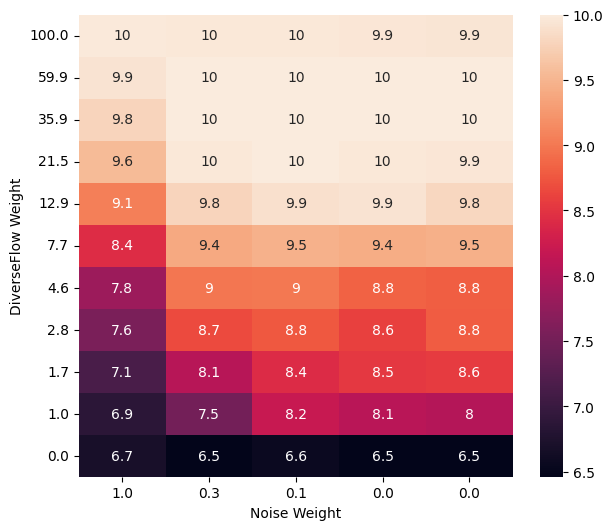

In [253]:
values_reversed_df = list(reversed([list(reversed(v)) for v in values_df]))
val_arr_df = np.array(values_reversed_df)

plt.figure()
ax = sns.heatmap(val_arr_df, annot=True,)
ax.set_xticks(0.5 + np.arange(len(possible_noise_weights)), labels = [f'{s:.01f}' for s in list(reversed(possible_noise_weights))], rotation=0)
ax.set_yticks(0.5 + np.arange(len(possible_W)), labels=[f'{s:.01f}' for s in list(reversed(possible_W))], rotation=0)
plt.xlabel("Noise Weight")
plt.ylabel("DiverseFlow Weight")
plt.show()